# ODE/FBA BioSimulators Composite

In [1]:
import sys, os
# get the path to the notebook, and change working directory
notebook_path = sys.path[0][:sys.path[0].index('notebooks')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])

In [9]:
from biosimulators_utils.sedml.data_model import ModelLanguage
from vivarium.core.engine import Engine, pf
from vivarium.core.composer import Composite
from vivarium.plots.topology import plot_topology
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium_biosimulators.library.mappings import tellurium_mapping
from vivarium_biosimulators.processes.biosimulator_process import BiosimulatorProcess
from vivarium_biosimulators.library.mappings import remove_multi_update
from vivarium_biosimulators.models.model_paths import MILLARD2016_PATH, BIGG_iAF1260b_PATH
import warnings; warnings.filterwarnings('ignore')

BIGG_MODEL_PATH = BIGG_iAF1260b_PATH
SBML_MODEL_PATH = MILLARD2016_PATH
TIME_STEP = 1
FLUX_TO_BOUNDS_MAP = {
    'dynamics_species_GLCp': 'value_parameter_R_EX_glc__D_e_upper_bound',
}

## Tellurium Process

### Generate a BioSimulators-Tellurium Vivarium process

In [15]:
# set up configuration
input_output_map = tellurium_mapping(SBML_MODEL_PATH)
input_variable_names = list(input_output_map.keys())
ode_config = {
    'biosimulator_api': 'biosimulators_tellurium',
    'model_source': SBML_MODEL_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'uniform_time_course',
    'input_ports': {
        'concentrations': input_variable_names,
    },
    'emit_ports': ['concentrations', 'outputs'],
    'time_step': TIME_STEP,
}

# make the process
ode_process = BiosimulatorProcess(ode_config)

### Generate a Tellurium composite
Composites have a topology, which allows us to connect the tellurium processes' initial state to outputs variables

In [4]:
renamed_concs = {
    input_name: (output_name,)
    for input_name, output_name in input_output_map.items()
}
ode_composite = Composite({
    'processes': {
        'ode': ode_process
    },
    'topology': {
        'ode': {
            'concentrations': {
                '_path': ('concentrations',),
                **renamed_concs
            },
            'outputs': ('concentrations',),
            'inputs': ('state',),
            'global': ('global',),
        }
    }
})

### Plot Tellurium topology

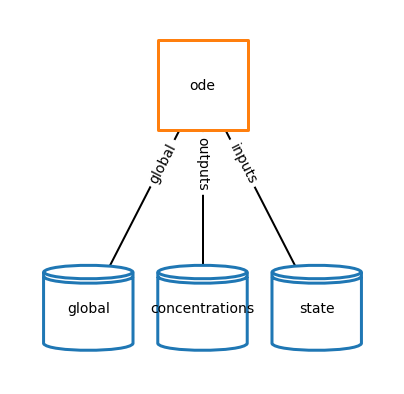

In [5]:
settings = {}
tellurium_topology = plot_topology(ode_composite, settings)

### Run a simulation

In [6]:
total_time = 30.

# get initial state from composite
ode_initial_state = ode_composite.initial_state()
ode_initial_state = remove_multi_update(ode_initial_state)

# make an experiment
ode_experiment = Engine(
    processes=ode_composite.processes,
    topology=ode_composite.topology,
    initial_state=ode_initial_state,
)
# run the simulation
ode_experiment.update(total_time)


Simulation ID: 1046e8ba-27aa-11ec-b390-8c85908ac627
Created: 10/07/2021 at 13:06:31
Completed in 0.085187 seconds


### Plot simulation output

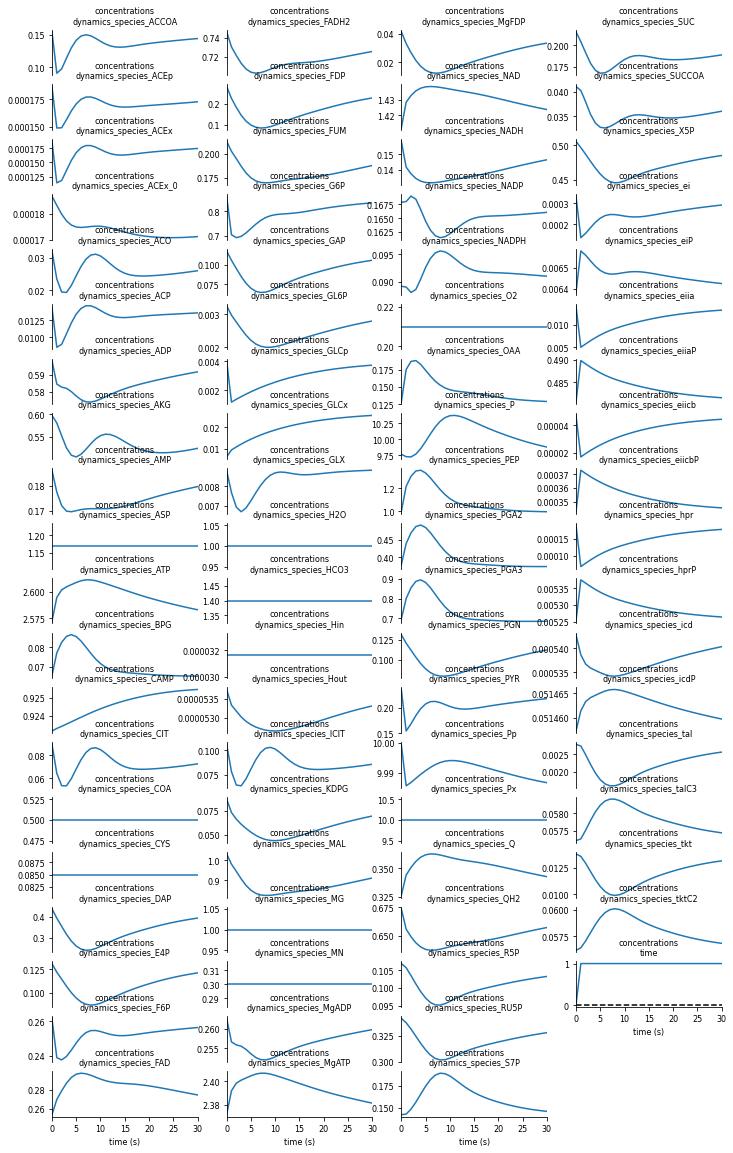

In [7]:
# get the data
ode_output = ode_experiment.emitter.get_timeseries()

settings = {'max_rows': 20}
fig = plot_simulation_output(ode_output, settings)

## COBRApy process

### Generate a BioSimulators-COBRApy Vivarium process

In [9]:
fba_config = {
    'biosimulator_api': 'biosimulators_cobrapy',
    'model_source': BIGG_MODEL_PATH,
    'model_language': ModelLanguage.SBML.value,
    'simulation': 'steady_state',
    'algorithm': {
        'kisao_id': 'KISAO_0000437',
    }
}
fba_process = BiosimulatorProcess(fba_config)

### Generate a COBRApy composite
Add a `Clock` Process that controls time, since COBRA is a deriver and would only run once on its own.

In [10]:
from vivarium.processes.clock import Clock
clock = Clock()

# make a composite
fba_composite = Composite({
    'processes': {
        'cobrapy': fba_process,
        'clock': clock
    },
    'topology': {
        'cobrapy': {
            'outputs': ('state',),
            'inputs': ('state',),
            'global': ('global',)
        },
        'clock': {
            'global_time': ('global', 'time',)
        }
    }
})

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


### Plot COBRA-Clock topology

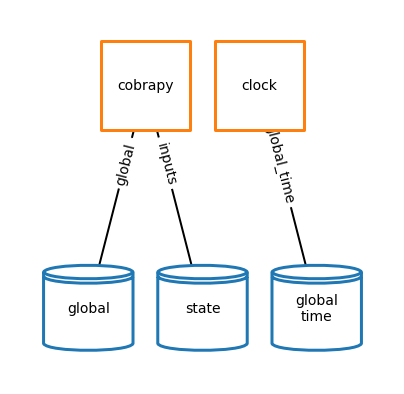

In [11]:
settings = {}
fba_topology = plot_topology(fba_composite, settings)

### Run a simulation

In [12]:
total_time = 2.

# get initial state from composite
fba_initial_state = fba_composite.initial_state()
fba_initial_state = remove_multi_update(fba_initial_state)

# make an experiment
cobrapy_experiment = Engine(
    processes=fba_composite.processes,
    topology=fba_composite.topology,
    initial_state=fba_initial_state,
)
# run the simulation
fba_experiment.update(total_time)


Simulation ID: e091804a-27a8-11ec-902e-8c85908ac627
Created: 10/07/2021 at 12:58:01
Completed in 11.45 seconds


### Plot simulation output

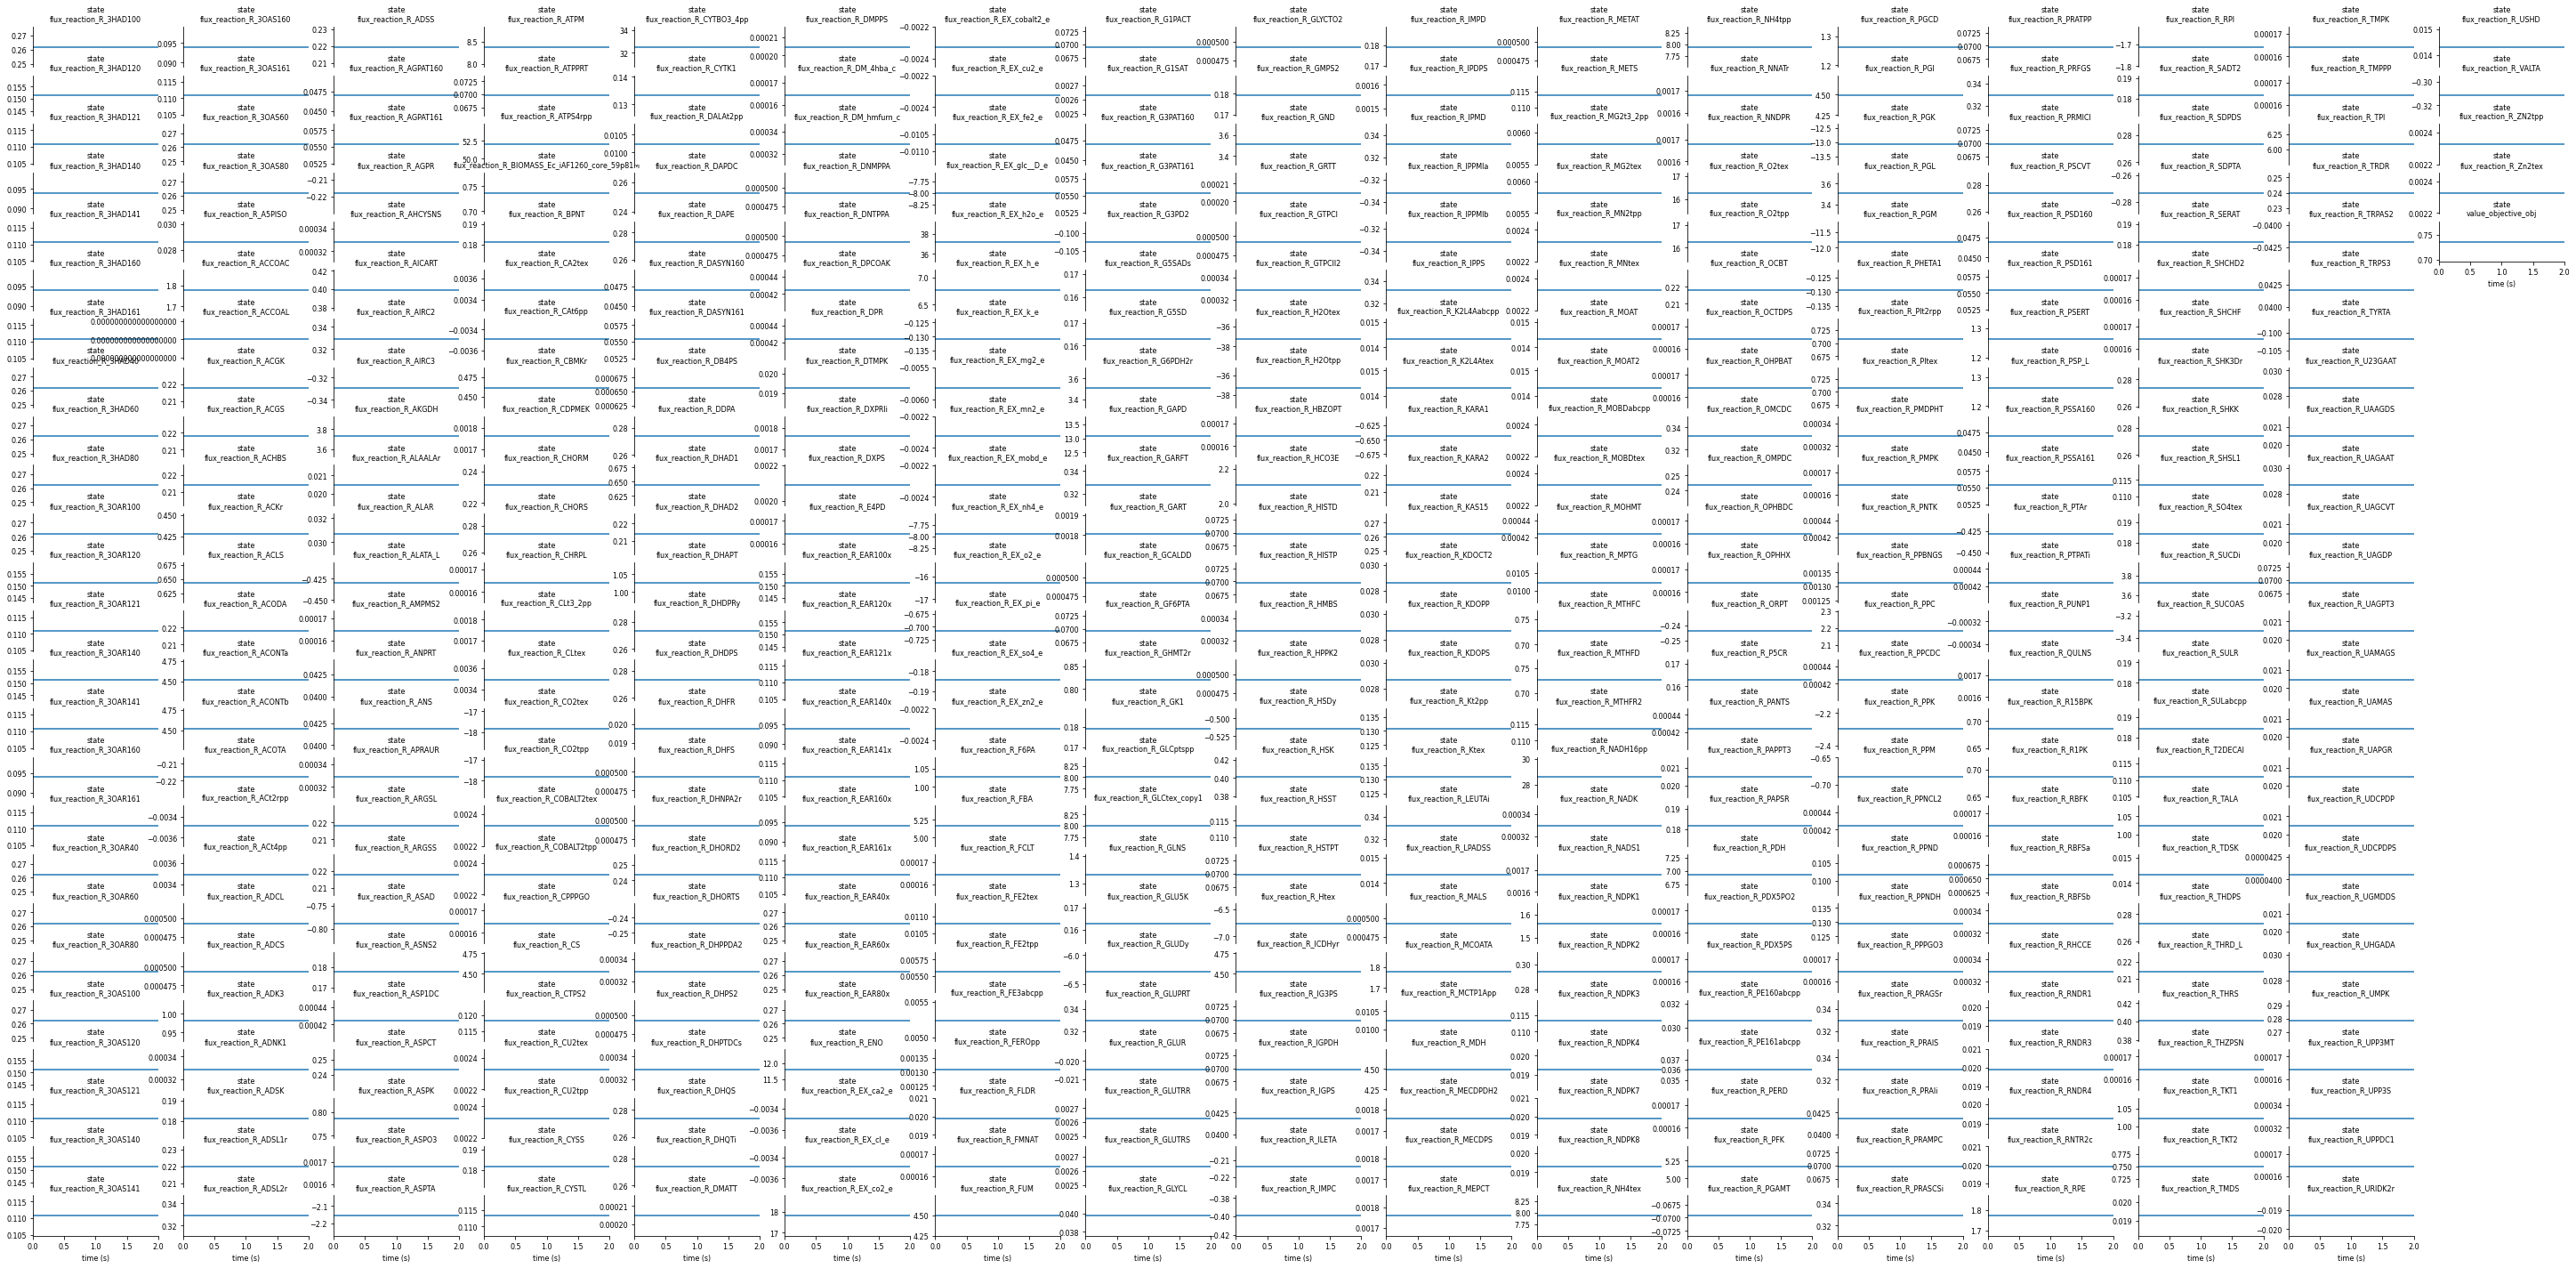

In [13]:
# get the data
fba_output = fba_experiment.emitter.get_timeseries()

settings = {'max_rows': 25}
fba_fig = plot_simulation_output(fba_output, settings)

## Flux Converter Process

In [16]:
from vivarium_biosimulators.processes.flux_bounds import FluxBoundsConverter

flux_ids = [rxn_id for rxn_id in FLUX_TO_BOUNDS_MAP.keys()]

# make the ode process
ode_config_2 = {
    'output_ports': {'fluxes': flux_ids},
    'emit_ports': ['outputs', 'fluxes'],
    **ode_config,
}
ode_process_2 = BiosimulatorProcess(ode_config_2)
        
# make the ode flux bounds converter process
flux_bounds_config = {
    'ode_process': ode_process_2,
    'flux_to_bound_map': FLUX_TO_BOUNDS_MAP,
    'flux_unit': 'mol/L',
    'bounds_unit': 'mmol/L/s',
}
ode_flux_converter = FluxBoundsConverter(flux_bounds_config)

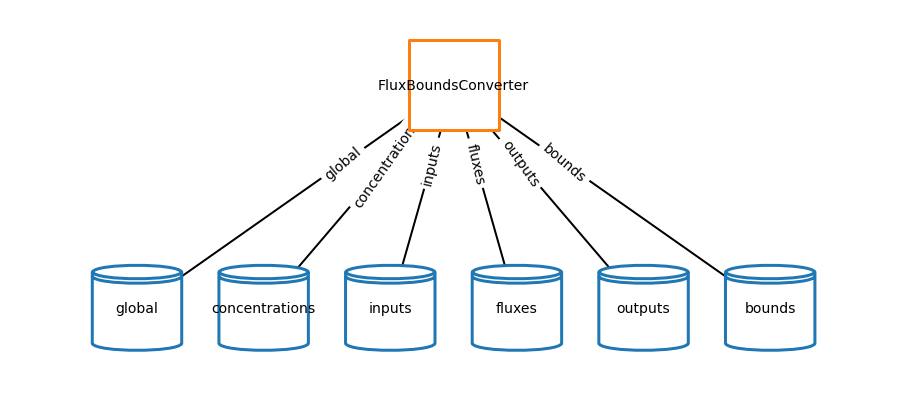

In [17]:
settings = {}
fba_topology = plot_topology(ode_flux_converter, settings)

## ODE_FBA Composite